# DeepSet Flow Matching Posterior Estimation with Burst Data

This notebook demonstrates how to perform flow matching posterior estimation (FMPE) using a DeepSet architecture with LAMPE, specifically tailored to handle burst data simulations.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko
import numpy as np

from itertools import islice
from lampe.data import JointLoader
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

from fmpe_deep_sets import DeepSetFMPE, DeepSetFMPELoss
from generate_burst_data import simulate_burst

## Simulator Setup

We define a simulator function that wraps around the `simulate_burst` function to ensure compatibility with our FMPE framework. This simulator will be permutation invariant to the order of the input parameters.

In [2]:
def burst_simulator_wrapper(theta: torch.Tensor) -> torch.Tensor:
    time = np.linspace(0, 10, 100)  # Example time array
    ncomp = 1  # Number of components in the burst model
    ybkg = 0.5  # Background flux

    # Ensure theta is at least 2D (batch dimension x parameter dimension)
    if theta.ndim == 1:
        theta = theta.unsqueeze(0)  # Add a batch dimension if it's not present

    ycounts = []
    for params in theta:
        burstparams = params.numpy()  # Convert parameters to numpy array
        # Ensure skew parameter is not zero to avoid division by zero
        epsilon = 1e-8
        burstparams[3] = max(burstparams[3], epsilon)  # Assuming skew is the fourth parameter

        ycount = simulate_burst(time, ncomp, burstparams, ybkg)
        ycounts.append(ycount)

    ycounts = np.array(ycounts)
    return torch.tensor(ycounts, dtype=torch.float32)

## Prior Distribution

We define a prior distribution for the parameters of the burst model. This prior will uniformly sample from specified lower and upper bounds for each parameter.

In [3]:
LOWER = torch.tensor([0.0, 0.0, 0.0, 0.0])  # Lower bounds for t0, amp, rise, skew
UPPER = torch.tensor([10.0, 10.0, 10.0, 10.0])  # Upper bounds for t0, amp, rise, skew
prior = zuko.distributions.BoxUniform(LOWER, UPPER)

## Data Loader Initialization

We initialize a `JointLoader` that will provide batches of parameters and corresponding simulated data for training.

In [4]:
loader = JointLoader(prior, burst_simulator_wrapper, batch_size=256, vectorized=True)

## Model and Loss Function

We define the `DeepSetFMPE` model and the corresponding loss function. The model is trained to estimate the posterior distribution of the parameters given the simulated data.

In [5]:
estimator = DeepSetFMPE(theta_dim=4, x_dim=100, freqs=5)  # Adjust dimensions accordingly
loss = DeepSetFMPELoss(estimator)
optimizer = optim.Adam(estimator.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 128)
step = GDStep(optimizer, clip=1.0)

## Training Loop

We train the model using the defined loss function and optimizer, iterating over batches of data provided by our loader.

In [6]:
estimator.train()

for epoch in (bar := trange(128, unit='epoch')):
    losses = []

    for theta, x in islice(loader, 256):  # 256 batches per epoch
        losses.append(step(loss(theta, x)))

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|██████████| 128/128 [04:15<00:00,  2.00s/epoch, loss=2.03]


## Inference and Visualization

After training, we perform inference to estimate the posterior distribution for a new set of observations and visualize the results.

In [7]:
theta_star = prior.sample()
x_star = burst_simulator_wrapper(theta_star)

# Ensure tensors have a batch dimension
if theta_star.ndim == 1:
    theta_star = theta_star.unsqueeze(0)
if x_star.ndim == 1:
    x_star = x_star.unsqueeze(0)

# Proceed with inference
estimator.eval()
with torch.no_grad():
    log_p = estimator.flow(x_star).log_prob(theta_star)
    samples = estimator.flow(x_star).sample((2**14,))

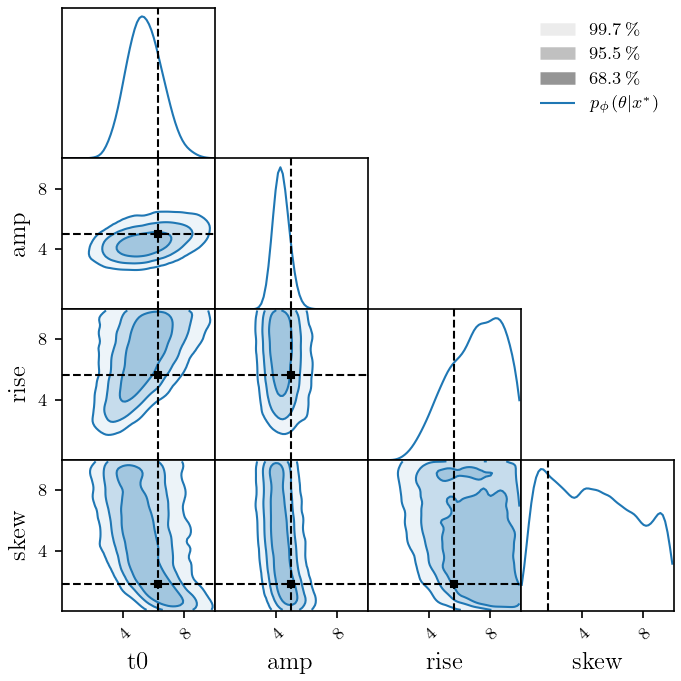

In [8]:
plt.rcParams.update(nice_rc(latex=True))

# Reshape samples to remove the middle dimension
# Convert from torch.Tensor to numpy array if necessary
samples_np = samples.squeeze(1).numpy()  # This changes shape from [16384, 1, 4] to [16384, 4]

# Now use the adjusted samples with the corner function
fig = corner(
    samples_np,
    smooth=2,
    domain=(LOWER.numpy(), UPPER.numpy()),  # Ensure domain bounds are also numpy arrays
    labels=['t0', 'amp', 'rise', 'skew'],
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)
mark_point(fig, theta_star.squeeze(0).numpy())  # Ensure theta_star is also correctly shaped

# Interpretation of Corner Plot Visualization

This visualization, commonly referred to as a "corner plot", is used in data analysis to present multidimensional distributions in a compact form. The corner plot allows us to visualize the posterior distributions and covariances between different parameters in a statistical model. Let's break down each component:

- **Diagonal Histograms:** 
  - Each histogram on the diagonal shows the marginal distribution of a single parameter. In this plot, the parameters are `t0`, `amp`, `rise`, and `skew`.
  - The histograms show where the bulk of the distribution lies and how spread out it is. For instance, `amp` appears to be sharply peaked around a value just above 4, indicating a strong estimation of this parameter.

- **Off-diagonal Contour Plots:**
  - The off-diagonal plots are pairwise scatter plots with contour lines, which show the joint distributions of two parameters.
  - The contours typically represent confidence intervals (68.3%, 95.5%, and 99.7%) akin to standard deviations in a Gaussian distribution.
  - We can assess correlations between parameters; for example, `t0` and `rise` show a clear positive correlation, indicated by the elongated contours along a line of positive slope.

- **Crosshair and Dotted Lines:**
  - The crosshairs (dashed lines) intersect at the most probable values (the mode) for the parameters, often considered the best-fit values in a Bayesian analysis context.
  - The position of the crosshair in the contour plots allows us to see the most probable combination of two parameters.

- **Annotations:**
  - $p(\theta|\mathbf{x})$ denotes the posterior probability distribution of the parameters (`θ`) given the data (`x`). It is the probability of the parameters being at a certain value given the observed data.
  - The colors in the contour plots likely correspond to different levels of the cumulative distribution, with darker shades indicating higher probability density.

This plot is typically generated using data analysis libraries in Python such as `matplotlib`, `seaborn`, or `corner.py`. It is a powerful tool in Bayesian data analysis for understanding the relationships between model parameters and assessing the certainty of our estimates.
